<a href="https://colab.research.google.com/github/Doctor9Trio/a3/blob/main/Copy_of_video_based_fight_detection_using_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fight detection in Video

NFT Assignment


*   BT21CSE011 - Vishal Raj
*   BT21CSE117 - Ravi Bishnoi


      

#### In this Assignment we have to Train the model to detect Fight in Video with help of Neural Network.

#### Due to the small size of the provided dataset, the model tend to overfit quickly. For Better results we have to train this model with a large datasets.




## Install Scikit-Video

In [40]:
!pip install scikit-video

## Import libraries

In [41]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import skvideo.io
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import io
import imageio
import ipywidgets
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K


## Add surveillance fight dataset from github

In [42]:
!git clone https://github.com/Doctor9Trio/a3.git

fatal: destination path 'a3' already exists and is not an empty directory.


## Load, resize and trim the videos

In [43]:
def frame_crop_center(video,cropf):
    f,_,_,_ = video.shape
    startf = f//2 - cropf//2
    return video[startf:startf+cropf, :, :, :]

fights=[]
nofights=[]

surv_fights=[]
surv_no_fights=[]

video_dims = []

####### Fight data
for filename in os.listdir('/content/a3/fight'):
    f = os.path.join('/content/a3/fight', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)
    L=[]

    #resize video dimensions
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)

    #center crop video to have consistent video frame number
    video = frame_crop_center(video, 42)

    fights.append(video)

for filename in os.listdir('/content/a3/fight'):
    f = os.path.join('/content/a3/fight', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)

    L=[]
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    video = frame_crop_center(video, 42)

    surv_fights.append(video)

####### Non Fight data
for filename in os.listdir('/content/a3/noFight'):
    f = os.path.join('/content/a3/noFight', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)

    L=[]
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    video = frame_crop_center(video, 42)

    nofights.append(video)

for filename in os.listdir('/content/a3/noFight'):
    f = os.path.join('/content/a3/noFight', filename)
    # checking if it is a file
    video = skvideo.io.vread(f)
    video_dims.append(video.shape)

    L=[]
    for i in range(video.shape[0]):
      frame = cv2.resize(video[i], (128,128), interpolation=cv2.INTER_CUBIC)
      L.append(frame)

    video = np.asarray(L)
    video = frame_crop_center(video, 42)

    surv_no_fights.append(video)

## Video duration and dimension analysis

The mean number of frames in the videos is 54 which corresponds to around 2 seconds.
To make the video duration consistent without losing lots of data the videos are trimmed to have 42 frames in total with a center crop.

Using a smaller frame number results in poorer performance.

In [44]:
data= pd.DataFrame(video_dims, columns=['frame_length', 'height', 'width', 'channels'])
data.describe()

,frame_length,height,width,channels
count,16.000000,16.000000,16.000000,16.0
mean,65.875000,345.000000,473.250000,3.0
std,12.409002,40.987803,18.444511,0.0
min,50.000000,240.000000,426.000000,3.0
25%,58.250000,360.000000,480.000000,3.0
50%,61.500000,360.000000,480.000000,3.0
75%,78.000000,360.000000,480.000000,3.0
max,85.000000,360.000000,480.000000,3.0


## Aggregate data and create labels

In [45]:
surv_fights = [video for video in surv_fights if video.shape[0] == 42]
surv_no_fights = [video for video in surv_no_fights if video.shape[0] == 42]

videos = fights + surv_fights + nofights + surv_no_fights
videos = np.asarray(videos)

labels = np.concatenate([np.ones(len(fights)+len(surv_fights)) , np.zeros(len(nofights)+len(surv_no_fights))])

del fights
del nofights
del surv_fights
del surv_no_fights

## Train, test, val split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(videos, labels, test_size=0.2, random_state=2334)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=124567)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10, 42, 128, 128, 3)
(2, 42, 128, 128, 3)
(4, 42, 128, 128, 3)


## Set ANN model hyperparameters

In [47]:
# ANN Hyperparameters
SEED = 77
BATCH_SIZE = 4
INPUT_SHAPE = (128, 128, 3)  # Adjusted input shape to match your data
NUM_CLASSES = 2
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
EPOCHS = 10

# You can keep these parameters for the ANN model architecture if desired
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# The following parameters are specific to the ViVit model and may not apply to a basic ANN
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 64
NUM_HEADS = 2
NUM_LAYERS = 2


In [48]:
# Setting seed for reproducibility
SEED = 77
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
tf.random.set_seed(SEED)

# DATA
DATASET_NAME = "fight/nofights"
BATCH_SIZE = 4
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (42, 128, 128, 3)
NUM_CLASSES = 2

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 10

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 64
NUM_HEADS = 2
NUM_LAYERS = 2

## Preprocess and prepare dataloader

Takes around 10 to 20 seconds to execute

In [49]:
@tf.function
def preprocess(frames: tf.Tensor, label: tf.Tensor):
    """Preprocess the frames tensors and parse the labels"""
    # Preprocess images
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )

    # Parse label
    label = tf.cast(label, tf.float32)
    return frames, label


def prepare_dataloader(
    videos: np.ndarray,
    labels: np.ndarray,
    loader_type: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Utility function to prepare dataloader"""
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = (
        dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    return dataloader


trainloader = prepare_dataloader(X_train, y_train, "train")
validloader = prepare_dataloader(X_val, y_val, "valid")
testloader = prepare_dataloader(X_test, y_test, "test")

## Define some model classes

In [50]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

## Create model

In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_ann_model(input_shape, num_classes):
    model = keras.Sequential([
        # Flatten the input
        layers.Flatten(input_shape=input_shape),
        # Add a dense layer with ReLU activation
        layers.Dense(128, activation='relu'),
        # Add a dropout layer for regularization
        layers.Dropout(0.5),
        # Add the output layer with softmax activation for classification
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Example usage of the ANN model creation function
input_shape = (128, 128, 3)  # Replace with your desired input shape
num_classes = 2  # Replace with the number of classes
ann_model = create_ann_model(input_shape, num_classes)

# Compile the model with an appropriate optimizer and loss function
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
ann_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 49152)             0         
                                                                 
 dense_10 (Dense)            (None, 128)               6291584   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 2)                 258       
                                                                 
Total params: 6291842 (24.00 MB)
Trainable params: 6291842 (24.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Define metrics, build, train and save ANN Model

In [52]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Define custom metrics
def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Define constants for the ANN
INPUT_SHAPE = (128, 128, 3)  # Replace with the desired input shape
NUM_CLASSES = 2  # Replace with the number of classes
LEARNING_RATE = 1e-4  # Replace with the desired learning rate
EPOCHS = 10  # Replace with the desired number of epochs

# Define mock data (replace with your actual data loading logic)
num_samples = 1000
x_train = np.random.rand(num_samples, *INPUT_SHAPE)
y_train = np.random.randint(NUM_CLASSES, size=num_samples)
x_valid = np.random.rand(num_samples // 5, *INPUT_SHAPE)
y_valid = np.random.randint(NUM_CLASSES, size=num_samples // 5)

# Define the ANN model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=INPUT_SHAPE),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model with the optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        recall_m,
        precision_m,
        f1_m,
    ]
)

# Print the model summary
model.summary()

# Train the ANN model
history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_valid, y_valid))

# Evaluate the model on the test data (replace with your test data)
# test_loss, test_accuracy, test_recall, test_precision, test_f1 = model.evaluate(testloader)
# print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")
# print(f"Test recall: {round(test_recall * 100, 2)}%")
# print(f"Test precision: {round(test_precision * 100, 2)}%")
# print(f"Test F1: {round(test_f1 * 100, 2)}%")

# Save the trained ANN model
model.save('/content/fight-detection-surv-dataset/ann_model.h5')


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 49152)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               6291584   
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 2)                 258       
                                                                 
Total params: 6291842 (24.00 MB)
Trainable params: 6291842 (24.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 3s 62ms/step - loss: 1.1881 - accuracy: 0.5170 - recall_m: 1.0000 - precision_m: 0.4951 - f1_m

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import keras.backend as K

# Define custom metric functions
def recall_m(y_true, y_pred):
    # Your recall metric code here
    pass

def precision_m(y_true, y_pred):
    # Your precision metric code here
    pass

def f1_m(y_true, y_pred):
    # Your F1 metric code here
    pass

# Register the custom metric functions
custom_objects = {'recall_m': recall_m, 'precision_m': precision_m, 'f1_m': f1_m}

# Load the model with custom metrics
model = load_model('/content/fight-detection-surv-dataset/ann_model.h5', custom_objects=custom_objects)


## Working


1/1 [==============================] - 0s 41ms/step


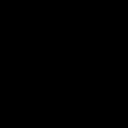

1/1 [==============================] - 0s 15ms/step


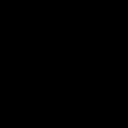

1/1 [==============================] - 0s 15ms/step


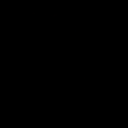

1/1 [==============================] - 0s 17ms/step


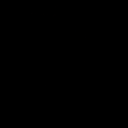

1/1 [==============================] - 0s 16ms/step


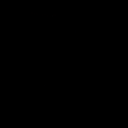

1/1 [==============================] - 0s 18ms/step


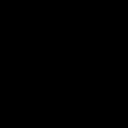

1/1 [==============================] - 0s 15ms/step


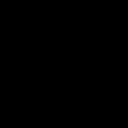

1/1 [==============================] - 0s 16ms/step


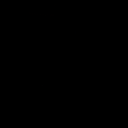

1/1 [==============================] - 0s 16ms/step


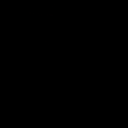

1/1 [==============================] - 0s 24ms/step


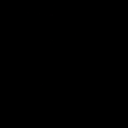

1/1 [==============================] - 0s 21ms/step


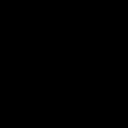

1/1 [==============================] - 0s 20ms/step


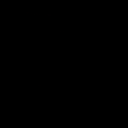

1/1 [==============================] - 0s 21ms/step


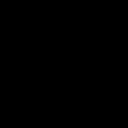

1/1 [==============================] - 0s 21ms/step


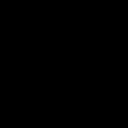

1/1 [==============================] - 0s 21ms/step


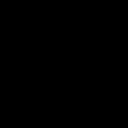

1/1 [==============================] - 0s 20ms/step


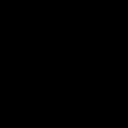

1/1 [==============================] - 0s 21ms/step


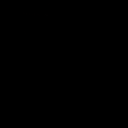

1/1 [==============================] - 0s 20ms/step


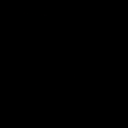

1/1 [==============================] - 0s 20ms/step


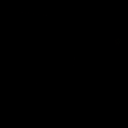

1/1 [==============================] - 0s 20ms/step


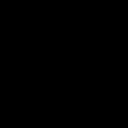

1/1 [==============================] - 0s 26ms/step


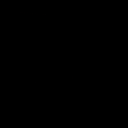

1/1 [==============================] - 0s 20ms/step


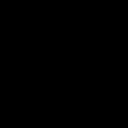

1/1 [==============================] - 0s 22ms/step


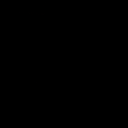

1/1 [==============================] - 0s 23ms/step


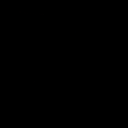

1/1 [==============================] - 0s 34ms/step


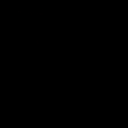

1/1 [==============================] - 0s 27ms/step


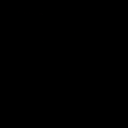

1/1 [==============================] - 0s 20ms/step


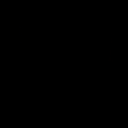

1/1 [==============================] - 0s 21ms/step


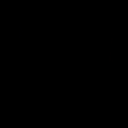

1/1 [==============================] - 0s 23ms/step


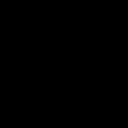

1/1 [==============================] - 0s 21ms/step


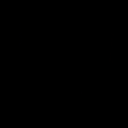

1/1 [==============================] - 0s 20ms/step


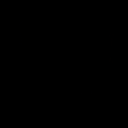

1/1 [==============================] - 0s 25ms/step


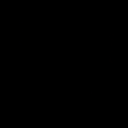

1/1 [==============================] - 0s 27ms/step


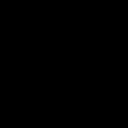

1/1 [==============================] - 0s 22ms/step


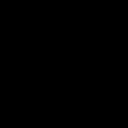

1/1 [==============================] - 0s 16ms/step


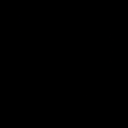

1/1 [==============================] - 0s 18ms/step


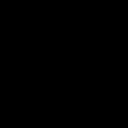

1/1 [==============================] - 0s 16ms/step


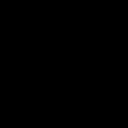

1/1 [==============================] - 0s 16ms/step


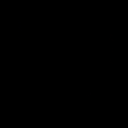

1/1 [==============================] - 0s 16ms/step


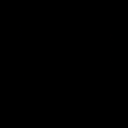

1/1 [==============================] - 0s 16ms/step


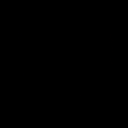

1/1 [==============================] - 0s 16ms/step


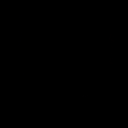

1/1 [==============================] - 0s 17ms/step


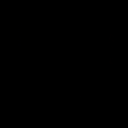

1/1 [==============================] - 0s 16ms/step


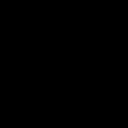

1/1 [==============================] - 0s 19ms/step


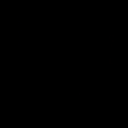

1/1 [==============================] - 0s 16ms/step


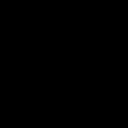

1/1 [==============================] - 0s 16ms/step


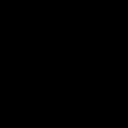

1/1 [==============================] - 0s 18ms/step


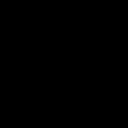

1/1 [==============================] - 0s 18ms/step


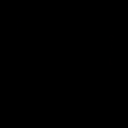

1/1 [==============================] - 0s 16ms/step


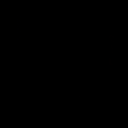

1/1 [==============================] - 0s 17ms/step


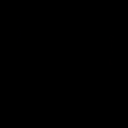

1/1 [==============================] - 0s 16ms/step


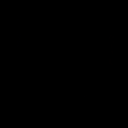

1/1 [==============================] - 0s 17ms/step


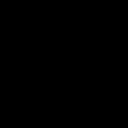

1/1 [==============================] - 0s 19ms/step


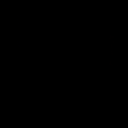

1/1 [==============================] - 0s 16ms/step


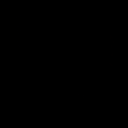

1/1 [==============================] - 0s 15ms/step


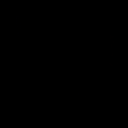

1/1 [==============================] - 0s 17ms/step


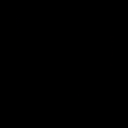

1/1 [==============================] - 0s 17ms/step


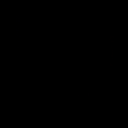

1/1 [==============================] - 0s 20ms/step


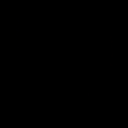

1/1 [==============================] - 0s 17ms/step


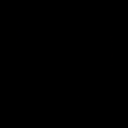

1/1 [==============================] - 0s 17ms/step


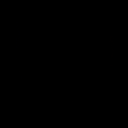

1/1 [==============================] - 0s 20ms/step


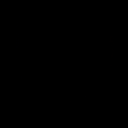

1/1 [==============================] - 0s 16ms/step


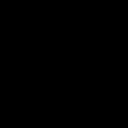

1/1 [==============================] - 0s 17ms/step


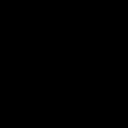

1/1 [==============================] - 0s 17ms/step


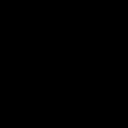

1/1 [==============================] - 0s 18ms/step


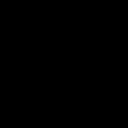

1/1 [==============================] - 0s 16ms/step


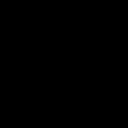

1/1 [==============================] - 0s 16ms/step


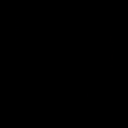

1/1 [==============================] - 0s 18ms/step


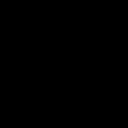

1/1 [==============================] - 0s 17ms/step


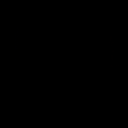

1/1 [==============================] - 0s 16ms/step


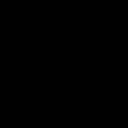

1/1 [==============================] - 0s 19ms/step


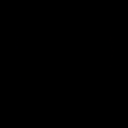

1/1 [==============================] - 0s 16ms/step


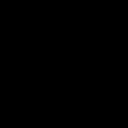

1/1 [==============================] - 0s 17ms/step


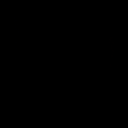

1/1 [==============================] - 0s 19ms/step


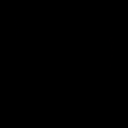

1/1 [==============================] - 0s 18ms/step


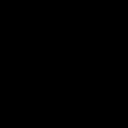

1/1 [==============================] - 0s 18ms/step


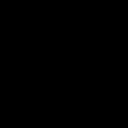

1/1 [==============================] - 0s 20ms/step


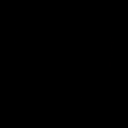

1/1 [==============================] - 0s 19ms/step


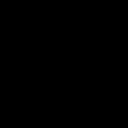

1/1 [==============================] - 0s 17ms/step


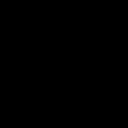

1/1 [==============================] - 0s 17ms/step


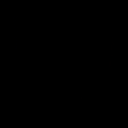

1/1 [==============================] - 0s 17ms/step


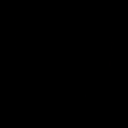

1/1 [==============================] - 0s 18ms/step


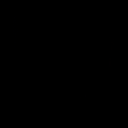

1/1 [==============================] - 0s 17ms/step


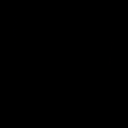

1/1 [==============================] - 0s 17ms/step


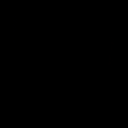

1/1 [==============================] - 0s 25ms/step


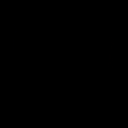

1/1 [==============================] - 0s 20ms/step


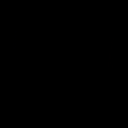

1/1 [==============================] - 0s 16ms/step


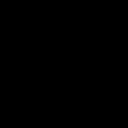

1/1 [==============================] - 0s 16ms/step


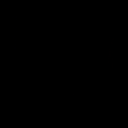

1/1 [==============================] - 0s 16ms/step


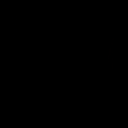

1/1 [==============================] - 0s 16ms/step


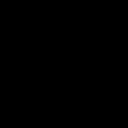

1/1 [==============================] - 0s 20ms/step


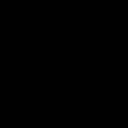

1/1 [==============================] - 0s 19ms/step


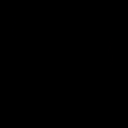

1/1 [==============================] - 0s 16ms/step


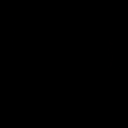

1/1 [==============================] - 0s 15ms/step


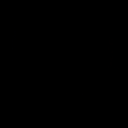

1/1 [==============================] - 0s 18ms/step


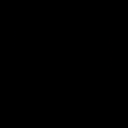

1/1 [==============================] - 0s 18ms/step


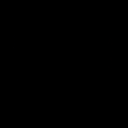

1/1 [==============================] - 0s 16ms/step


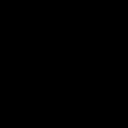

1/1 [==============================] - 0s 16ms/step


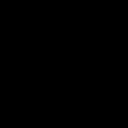

1/1 [==============================] - 0s 16ms/step


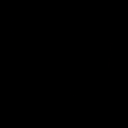

1/1 [==============================] - 0s 15ms/step


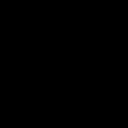

1/1 [==============================] - 0s 15ms/step


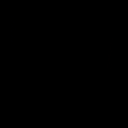

1/1 [==============================] - 0s 20ms/step


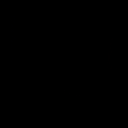

1/1 [==============================] - 0s 17ms/step


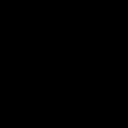

1/1 [==============================] - 0s 16ms/step


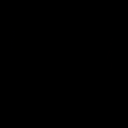

1/1 [==============================] - 0s 16ms/step


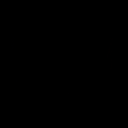

1/1 [==============================] - 0s 16ms/step


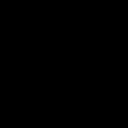

1/1 [==============================] - 0s 16ms/step


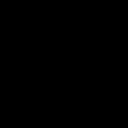

1/1 [==============================] - 0s 17ms/step


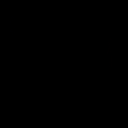

1/1 [==============================] - 0s 21ms/step


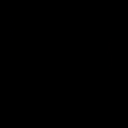

1/1 [==============================] - 0s 16ms/step


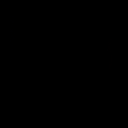

1/1 [==============================] - 0s 16ms/step


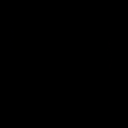

1/1 [==============================] - 0s 17ms/step


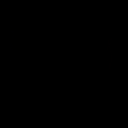

1/1 [==============================] - 0s 17ms/step


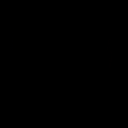

1/1 [==============================] - 0s 16ms/step


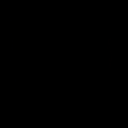

1/1 [==============================] - 0s 16ms/step


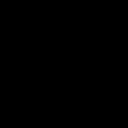

1/1 [==============================] - 0s 16ms/step


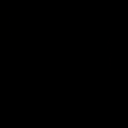

1/1 [==============================] - 0s 16ms/step


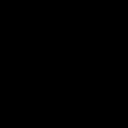

1/1 [==============================] - 0s 18ms/step


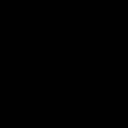

1/1 [==============================] - 0s 17ms/step


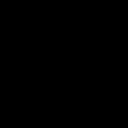

1/1 [==============================] - 0s 16ms/step


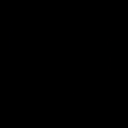

1/1 [==============================] - 0s 17ms/step


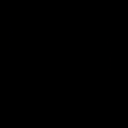

1/1 [==============================] - 0s 16ms/step


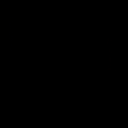

1/1 [==============================] - 0s 18ms/step


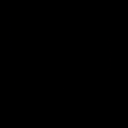

1/1 [==============================] - 0s 18ms/step


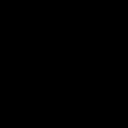

1/1 [==============================] - 0s 19ms/step


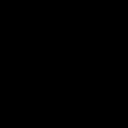

1/1 [==============================] - 0s 16ms/step


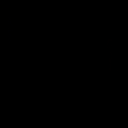

1/1 [==============================] - 0s 15ms/step


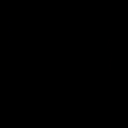

1/1 [==============================] - 0s 18ms/step


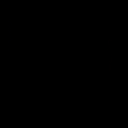

1/1 [==============================] - 0s 16ms/step


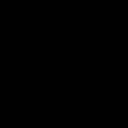

1/1 [==============================] - 0s 16ms/step


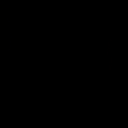

1/1 [==============================] - 0s 17ms/step


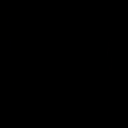

1/1 [==============================] - 0s 17ms/step


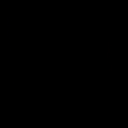

1/1 [==============================] - 0s 18ms/step


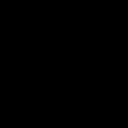

1/1 [==============================] - 0s 17ms/step


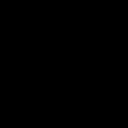

1/1 [==============================] - 0s 17ms/step


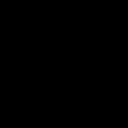

1/1 [==============================] - 0s 15ms/step


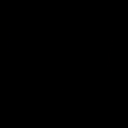

1/1 [==============================] - 0s 20ms/step


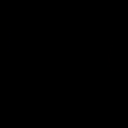

1/1 [==============================] - 0s 16ms/step


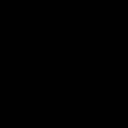

1/1 [==============================] - 0s 17ms/step


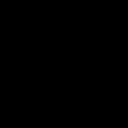

1/1 [==============================] - 0s 16ms/step


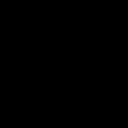

1/1 [==============================] - 0s 18ms/step


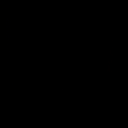

1/1 [==============================] - 0s 16ms/step


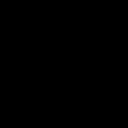

1/1 [==============================] - 0s 16ms/step


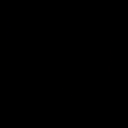

1/1 [==============================] - 0s 15ms/step


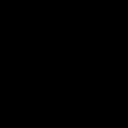

1/1 [==============================] - 0s 18ms/step


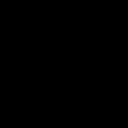

1/1 [==============================] - 0s 15ms/step


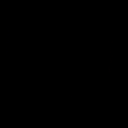

1/1 [==============================] - 0s 20ms/step


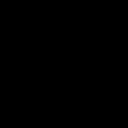

1/1 [==============================] - 0s 17ms/step


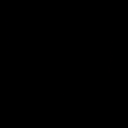

1/1 [==============================] - 0s 16ms/step


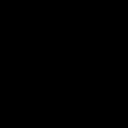

1/1 [==============================] - 0s 16ms/step


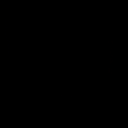

1/1 [==============================] - 0s 18ms/step


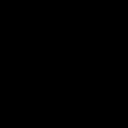

1/1 [==============================] - 0s 20ms/step


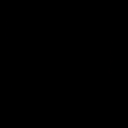

1/1 [==============================] - 0s 16ms/step


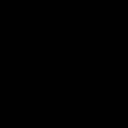

1/1 [==============================] - 0s 16ms/step


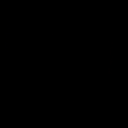

1/1 [==============================] - 0s 17ms/step


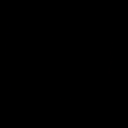

1/1 [==============================] - 0s 15ms/step


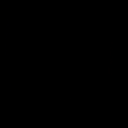

1/1 [==============================] - 0s 16ms/step


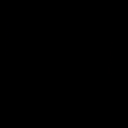

1/1 [==============================] - 0s 24ms/step


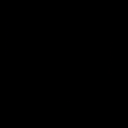

1/1 [==============================] - 0s 20ms/step


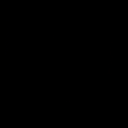

1/1 [==============================] - 0s 23ms/step


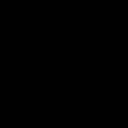

1/1 [==============================] - 0s 20ms/step


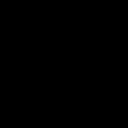

1/1 [==============================] - 0s 19ms/step


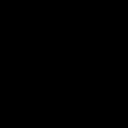

1/1 [==============================] - 0s 20ms/step


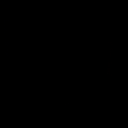

1/1 [==============================] - 0s 20ms/step


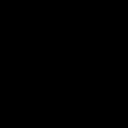

1/1 [==============================] - 0s 20ms/step


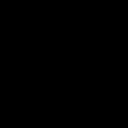

1/1 [==============================] - 0s 21ms/step


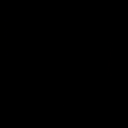

1/1 [==============================] - 0s 20ms/step


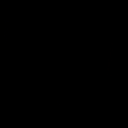

1/1 [==============================] - 0s 21ms/step


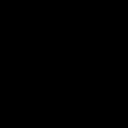

1/1 [==============================] - 0s 22ms/step


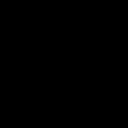

1/1 [==============================] - 0s 20ms/step


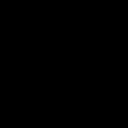

1/1 [==============================] - 0s 25ms/step


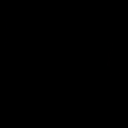

1/1 [==============================] - 0s 18ms/step


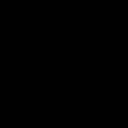

1/1 [==============================] - 0s 23ms/step


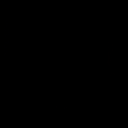

1/1 [==============================] - 0s 20ms/step


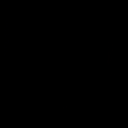

1/1 [==============================] - 0s 19ms/step


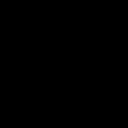

1/1 [==============================] - 0s 20ms/step


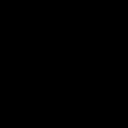

1/1 [==============================] - 0s 21ms/step


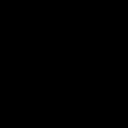

1/1 [==============================] - 0s 27ms/step


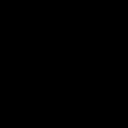

1/1 [==============================] - 0s 21ms/step


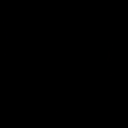

1/1 [==============================] - 0s 24ms/step


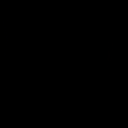

1/1 [==============================] - 0s 22ms/step


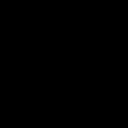

1/1 [==============================] - 0s 21ms/step


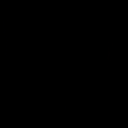

1/1 [==============================] - 0s 21ms/step


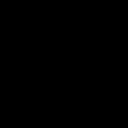

1/1 [==============================] - 0s 22ms/step


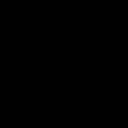

1/1 [==============================] - 0s 24ms/step


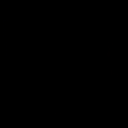

1/1 [==============================] - 0s 20ms/step


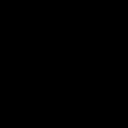

1/1 [==============================] - 0s 22ms/step


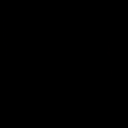

1/1 [==============================] - 0s 22ms/step


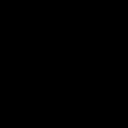

1/1 [==============================] - 0s 19ms/step


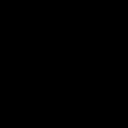

1/1 [==============================] - 0s 21ms/step


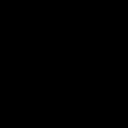

1/1 [==============================] - 0s 21ms/step


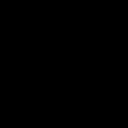

1/1 [==============================] - 0s 20ms/step


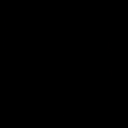

1/1 [==============================] - 0s 29ms/step


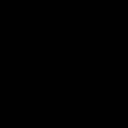

1/1 [==============================] - 0s 24ms/step


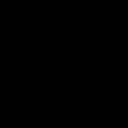

1/1 [==============================] - 0s 21ms/step


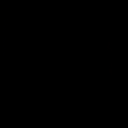

1/1 [==============================] - 0s 19ms/step


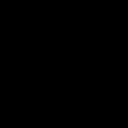

1/1 [==============================] - 0s 23ms/step


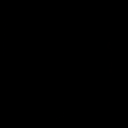

1/1 [==============================] - 0s 20ms/step


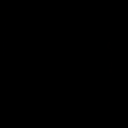

1/1 [==============================] - 0s 21ms/step


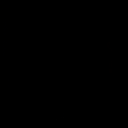

1/1 [==============================] - 0s 20ms/step


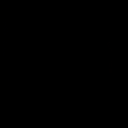

1/1 [==============================] - 0s 18ms/step


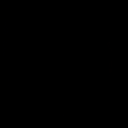

1/1 [==============================] - 0s 18ms/step


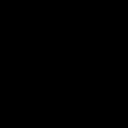

1/1 [==============================] - 0s 29ms/step


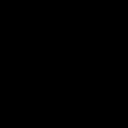

1/1 [==============================] - 0s 37ms/step


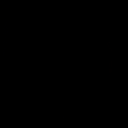

1/1 [==============================] - 0s 22ms/step


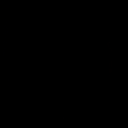

1/1 [==============================] - 0s 28ms/step


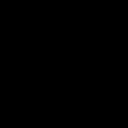

1/1 [==============================] - 0s 32ms/step


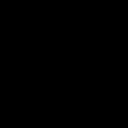

1/1 [==============================] - 0s 24ms/step


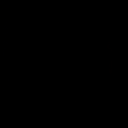

1/1 [==============================] - 0s 22ms/step


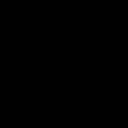

1/1 [==============================] - 0s 23ms/step


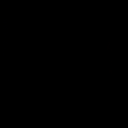

1/1 [==============================] - 0s 22ms/step


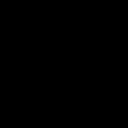

1/1 [==============================] - 0s 22ms/step


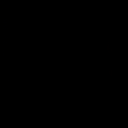

1/1 [==============================] - 0s 24ms/step


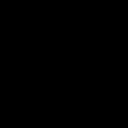

1/1 [==============================] - 0s 25ms/step


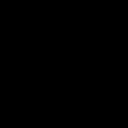

1/1 [==============================] - 0s 21ms/step


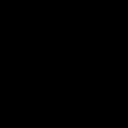

1/1 [==============================] - 0s 22ms/step


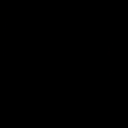

1/1 [==============================] - 0s 22ms/step


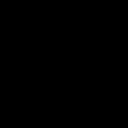

1/1 [==============================] - 0s 22ms/step


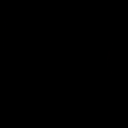

1/1 [==============================] - 0s 22ms/step


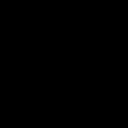

1/1 [==============================] - 0s 26ms/step


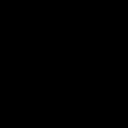

1/1 [==============================] - 0s 21ms/step


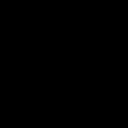

1/1 [==============================] - 0s 28ms/step


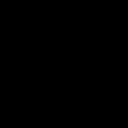

1/1 [==============================] - 0s 20ms/step


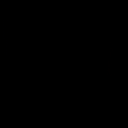

1/1 [==============================] - 0s 20ms/step


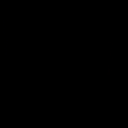

1/1 [==============================] - 0s 23ms/step


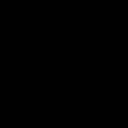

1/1 [==============================] - 0s 24ms/step


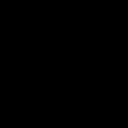

1/1 [==============================] - 0s 24ms/step


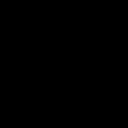

1/1 [==============================] - 0s 23ms/step


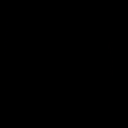

1/1 [==============================] - 0s 16ms/step


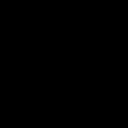

1/1 [==============================] - 0s 21ms/step


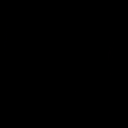

1/1 [==============================] - 0s 17ms/step


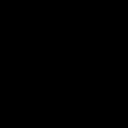

1/1 [==============================] - 0s 16ms/step


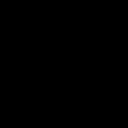

1/1 [==============================] - 0s 16ms/step


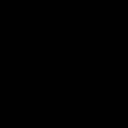

1/1 [==============================] - 0s 16ms/step


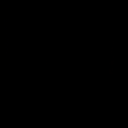

1/1 [==============================] - 0s 17ms/step


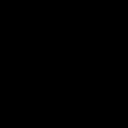

1/1 [==============================] - 0s 16ms/step


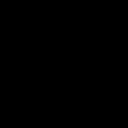

1/1 [==============================] - 0s 16ms/step


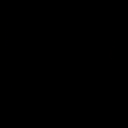

1/1 [==============================] - 0s 16ms/step


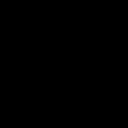

1/1 [==============================] - 0s 16ms/step


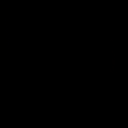

1/1 [==============================] - 0s 19ms/step


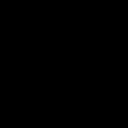

1/1 [==============================] - 0s 17ms/step


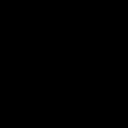

1/1 [==============================] - 0s 17ms/step


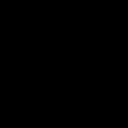

1/1 [==============================] - 0s 18ms/step


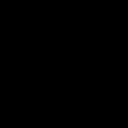

1/1 [==============================] - 0s 17ms/step


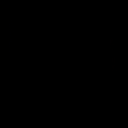

1/1 [==============================] - 0s 21ms/step


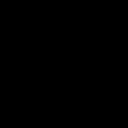

1/1 [==============================] - 0s 24ms/step


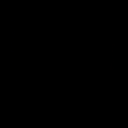

1/1 [==============================] - 0s 17ms/step


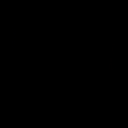

1/1 [==============================] - 0s 17ms/step


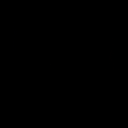

1/1 [==============================] - 0s 16ms/step


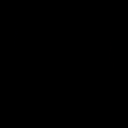

1/1 [==============================] - 0s 17ms/step


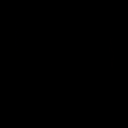

1/1 [==============================] - 0s 20ms/step


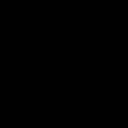

1/1 [==============================] - 0s 18ms/step


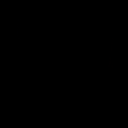

1/1 [==============================] - 0s 17ms/step


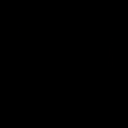

1/1 [==============================] - 0s 17ms/step


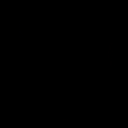

1/1 [==============================] - 0s 18ms/step


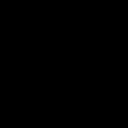

1/1 [==============================] - 0s 16ms/step


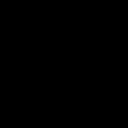

1/1 [==============================] - 0s 20ms/step


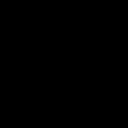

1/1 [==============================] - 0s 18ms/step


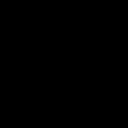

1/1 [==============================] - 0s 18ms/step


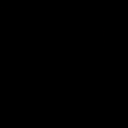

1/1 [==============================] - 0s 17ms/step


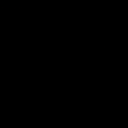

1/1 [==============================] - 0s 18ms/step


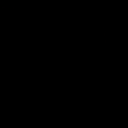

1/1 [==============================] - 0s 17ms/step


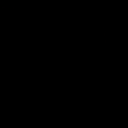

1/1 [==============================] - 0s 17ms/step


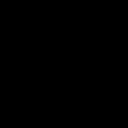

1/1 [==============================] - 0s 16ms/step


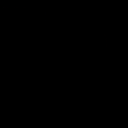

1/1 [==============================] - 0s 16ms/step


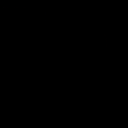

1/1 [==============================] - 0s 17ms/step


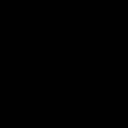

1/1 [==============================] - 0s 17ms/step


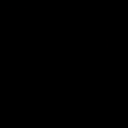

1/1 [==============================] - 0s 16ms/step


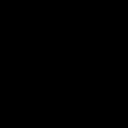

1/1 [==============================] - 0s 19ms/step


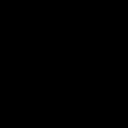

1/1 [==============================] - 0s 17ms/step


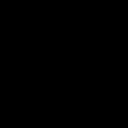

1/1 [==============================] - 0s 17ms/step


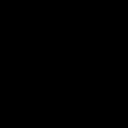

1/1 [==============================] - 0s 17ms/step


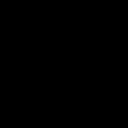

1/1 [==============================] - 0s 16ms/step


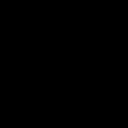

1/1 [==============================] - 0s 18ms/step


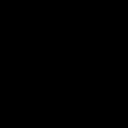

1/1 [==============================] - 0s 19ms/step


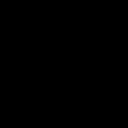

1/1 [==============================] - 0s 19ms/step


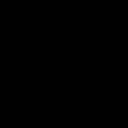

1/1 [==============================] - 0s 17ms/step


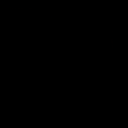

1/1 [==============================] - 0s 16ms/step


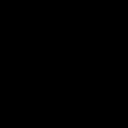

1/1 [==============================] - 0s 17ms/step


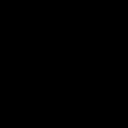

1/1 [==============================] - 0s 17ms/step


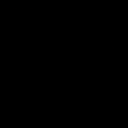

1/1 [==============================] - 0s 17ms/step


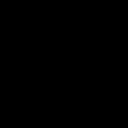

1/1 [==============================] - 0s 18ms/step


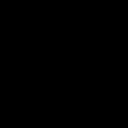

1/1 [==============================] - 0s 15ms/step


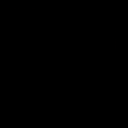

1/1 [==============================] - 0s 18ms/step


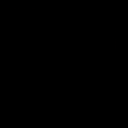

1/1 [==============================] - 0s 16ms/step


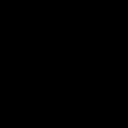

1/1 [==============================] - 0s 17ms/step


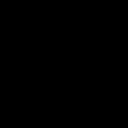

1/1 [==============================] - 0s 17ms/step


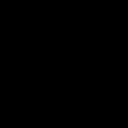

1/1 [==============================] - 0s 16ms/step


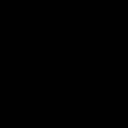

1/1 [==============================] - 0s 17ms/step


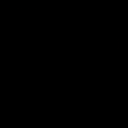

1/1 [==============================] - 0s 16ms/step


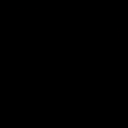

1/1 [==============================] - 0s 17ms/step


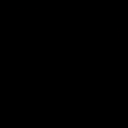

1/1 [==============================] - 0s 17ms/step


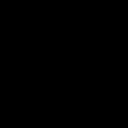

1/1 [==============================] - 0s 16ms/step


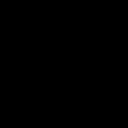

1/1 [==============================] - 0s 17ms/step


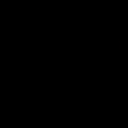

1/1 [==============================] - 0s 16ms/step


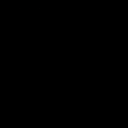

1/1 [==============================] - 0s 16ms/step


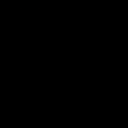

1/1 [==============================] - 0s 16ms/step


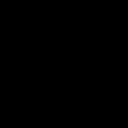

1/1 [==============================] - 0s 16ms/step


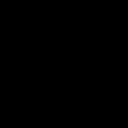

1/1 [==============================] - 0s 17ms/step


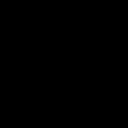

1/1 [==============================] - 0s 19ms/step


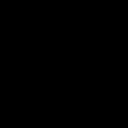

1/1 [==============================] - 0s 16ms/step


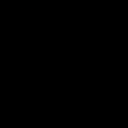

1/1 [==============================] - 0s 16ms/step


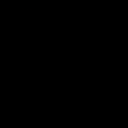

1/1 [==============================] - 0s 17ms/step


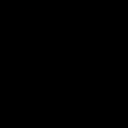

1/1 [==============================] - 0s 16ms/step


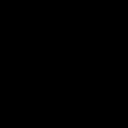

1/1 [==============================] - 0s 15ms/step


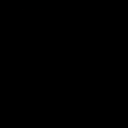

1/1 [==============================] - 0s 15ms/step


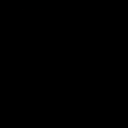

1/1 [==============================] - 0s 15ms/step


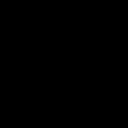

1/1 [==============================] - 0s 16ms/step


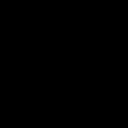

1/1 [==============================] - 0s 17ms/step


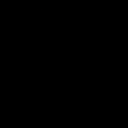

1/1 [==============================] - 0s 18ms/step


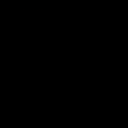

1/1 [==============================] - 0s 16ms/step


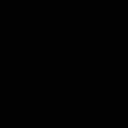

1/1 [==============================] - 0s 15ms/step


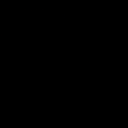

1/1 [==============================] - 0s 17ms/step


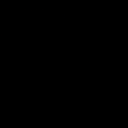

1/1 [==============================] - 0s 15ms/step


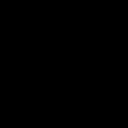

1/1 [==============================] - 0s 15ms/step


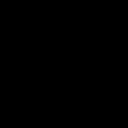

1/1 [==============================] - 0s 16ms/step


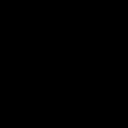

1/1 [==============================] - 0s 15ms/step


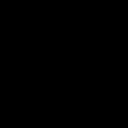

1/1 [==============================] - 0s 15ms/step


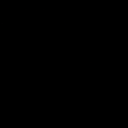

1/1 [==============================] - 0s 18ms/step


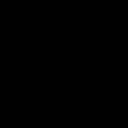

1/1 [==============================] - 0s 17ms/step


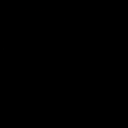

1/1 [==============================] - 0s 20ms/step


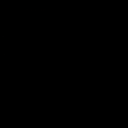

1/1 [==============================] - 0s 18ms/step


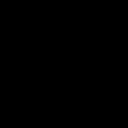

1/1 [==============================] - 0s 16ms/step


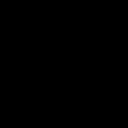

1/1 [==============================] - 0s 16ms/step


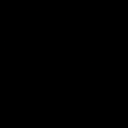

1/1 [==============================] - 0s 17ms/step


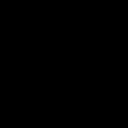

1/1 [==============================] - 0s 18ms/step


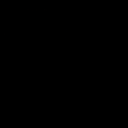

1/1 [==============================] - 0s 19ms/step


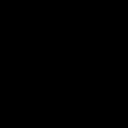

1/1 [==============================] - 0s 16ms/step


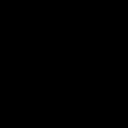

1/1 [==============================] - 0s 18ms/step


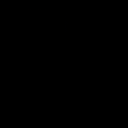

1/1 [==============================] - 0s 17ms/step


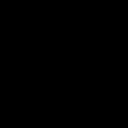

1/1 [==============================] - 0s 17ms/step


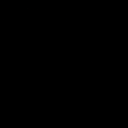

1/1 [==============================] - 0s 18ms/step


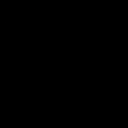

1/1 [==============================] - 0s 17ms/step


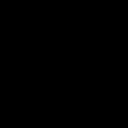

1/1 [==============================] - 0s 18ms/step


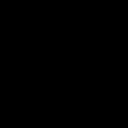

1/1 [==============================] - 0s 17ms/step


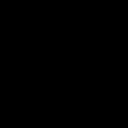

1/1 [==============================] - 0s 17ms/step


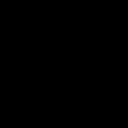

1/1 [==============================] - 0s 18ms/step


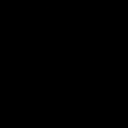

1/1 [==============================] - 0s 16ms/step


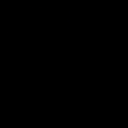

1/1 [==============================] - 0s 15ms/step


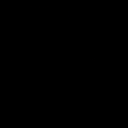

1/1 [==============================] - 0s 16ms/step


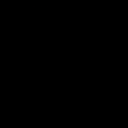

1/1 [==============================] - 0s 17ms/step


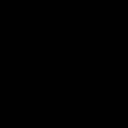

1/1 [==============================] - 0s 17ms/step


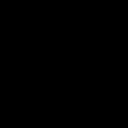

1/1 [==============================] - 0s 16ms/step


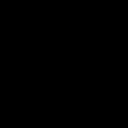

1/1 [==============================] - 0s 15ms/step


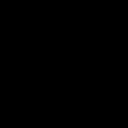

1/1 [==============================] - 0s 16ms/step


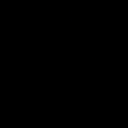

1/1 [==============================] - 0s 16ms/step


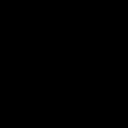

1/1 [==============================] - 0s 16ms/step


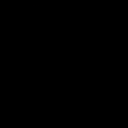

1/1 [==============================] - 0s 16ms/step


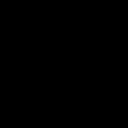

1/1 [==============================] - 0s 16ms/step


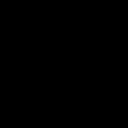

1/1 [==============================] - 0s 16ms/step


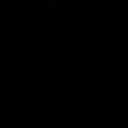

1/1 [==============================] - 0s 16ms/step


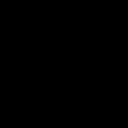

1/1 [==============================] - 0s 16ms/step


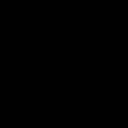

1/1 [==============================] - 0s 16ms/step


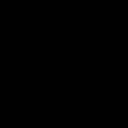

1/1 [==============================] - 0s 16ms/step


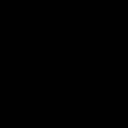

1/1 [==============================] - 0s 18ms/step


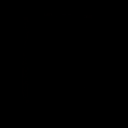

1/1 [==============================] - 0s 16ms/step


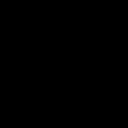

1/1 [==============================] - 0s 16ms/step


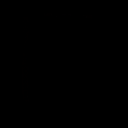

1/1 [==============================] - 0s 15ms/step


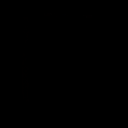

1/1 [==============================] - 0s 16ms/step


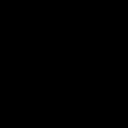

1/1 [==============================] - 0s 16ms/step


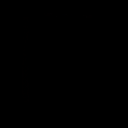

1/1 [==============================] - 0s 15ms/step


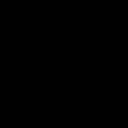

1/1 [==============================] - 0s 18ms/step


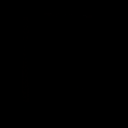

1/1 [==============================] - 0s 15ms/step


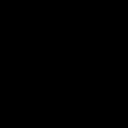

1/1 [==============================] - 0s 15ms/step


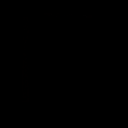

1/1 [==============================] - 0s 15ms/step


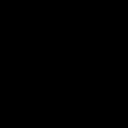

1/1 [==============================] - 0s 16ms/step


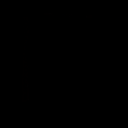

1/1 [==============================] - 0s 17ms/step


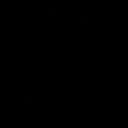

Error reading video frame


In [60]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import tensorflow as tf

# Load the pre-trained fight detection model with custom metrics
model = tf.keras.models.load_model(
    '/content/fight-detection-surv-dataset/ann_model.h5',
    custom_objects={'recall_m': recall_m, 'precision_m': precision_m, 'f1_m': f1_m}
)

# Open the video file
video_path = '/content/fight-detection-surv-dataset/test.mp4'
cap = cv2.VideoCapture(video_path)


# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error opening video file")
    exit()

while True:
    # Read the frame from the video
    ret, frame = cap.read()

    # Check if the frame was successfully read
    if not ret:
        print("Error reading video frame")
        break

    # Preprocess the frame
    frame = cv2.resize(frame, (128, 128))  # Resize the frame to (128, 128)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB color format
    frame = frame / 255.0  # Normalize pixel values to the range [0, 1]

    # Make predictions using the loaded model
    prediction = model.predict(np.expand_dims(frame, axis=0))

    # Assuming 0.5 as a threshold for fight detection
    is_fight = prediction[0][0] > 0.5

    if is_fight:
        # Take action when a fight is detected
        print("Fight detected!")

    # Display the frame with detection result
    cv2_imshow(frame)

    # Introduce a delay for frame display (e.g., 10 milliseconds)
    cv2.waitKey(10)

    # Exit the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video file and close windows
cap.release()
cv2.destroyAllWindows()
